In [1]:
import json
import numpy as np

from mpl_toolkits import mplot3d
%matplotlib inline
# for creating a responsive plot
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

In [2]:
data_file = 'MMM_G26_T.json'
meta_data_file = 'MMM_Task.meta.json'

In [3]:
f = open(data_file)
data = json.load(f)

f = open(meta_data_file)
meta = json.load(f)
meta = meta[0]["individuals"]

id_to_class = {}
for m in meta:
    id_to_class[m["id"]] = m["class"]

In [4]:
# data has the format 
# [{
# "_id": {"$oid": string}, 
#  "timestamp": float, 
#  "individuals": [{
#      "id": string, 
#      "loc": {
#          "x": float, 
#          "y": float, 
#          "z": float
#      }, 
#      "quat": [{
#          "x": float, 
#          "y": float, 
#          "z": float,
#          "w": float
#      }, 
#      "pose": [floats]
#      }
# }, ...] // end individuals
# }, ...] // end timestamps
# this function brings it to this format which is more focused on one object an has the location of every timestamp
# {id: { 
#    timespamp0: {'x': 21.064773559570312, 'y': 235.66290283203125, 'z': 148.31167602539062}, 
#    timestamp1: {...}
#    ...
# },
# id: { ...},
# ...
# }
def restructure_data(data):
    data_by_id = {}
    
    for i, document in enumerate(data):
        individuals = document["individuals"]
        for j, individual in enumerate(individuals):
            object_id = individual["id"]
            if object_id not in data_by_id:
                data_by_id[object_id] = {}
            (data_by_id[object_id])[document["timestamp"]] = individual["loc"]
            
        skel_individuals = document["skel_individuals"]
        for j, skel_individual in enumerate(skel_individuals):
            object_id = skel_individual["id"]
            if object_id not in data_by_id:
                data_by_id[object_id] = {}
            (data_by_id[object_id])[document["timestamp"]] = individual["loc"]
    return data_by_id

In [5]:
def get_trajectory_by_id_transposed(object_id):
    object_data = restructure_data(data)[object_id]
    shape = 4, len(object_data)
    trajectory = np.zeros(shape)
    for i, (timestamp, location) in enumerate(object_data.items()):
        for j in range(3):
            trajectory[j][i] = list(location.values())[j]
            trajectory[3][i] = timestamp
    return trajectory

In [6]:
# Uses restructered dataset to get the trajectory of an object with shape (4, timesteps)
def get_trajectory_by_id(object_id):
    object_data = restructure_data(data)[object_id]
    shape = len(object_data), 4
    trajectory = np.zeros(shape)
    for i, (timestamp, location) in enumerate(object_data.items()):
        for j in range(3):
            trajectory[i][j] = list(location.values())[j]
            trajectory[i][3] = timestamp
    return trajectory

In [7]:
# Returns false if there is no movemoment. Input: np array with shape: (4, timesteps)
def detect_movement(trajectory):
    result = []
    for axis in trajectory.T[0:3]:
        if len(set(axis)) == 1:
            result.append(False)
        else:
            result.append(True)
    return any(result)

In [8]:
# Older but faster Interactive 3D Plot with mathplotlib
def plot_trajectory_fast(object_id):
    trajectory = get_trajectory_by_id_transposed(object_id)
    if not detect_movement(trajectory.T):
        print(f"No movement for {id_to_class[object_id]}: {object_id} detected")
    else: 
        fig = plt.figure()
        ax = plt.axes(projection='3d')

        # creating the plot
        ax.plot3D(*trajectory[:3], color='green')
        ax.scatter3D(*trajectory[:3], color='green')
        

        ax.text(*trajectory[:3,0],  '%s' % (str(trajectory[3,0])), zorder=1, color='k')
        ax.text(*trajectory[:3,-1],  '%s' % (str(trajectory[3,-1])), zorder=1, color='k')
  
        # setting title and labels
        ax.set_xlabel('x-axis')
        ax.set_ylabel('y-axis')
        ax.set_zlabel('z-axis')
        ax.set_title(f"{id_to_class[object_id]}: {object_id}")
        plt.show()

In [9]:
# Plots the trajectory of the object in an interactive 3D Chart
def plot_trajectory(object_id):
    trajectory = get_trajectory_by_id(object_id)
    
    if not detect_movement(trajectory):
        print(f"No movement for {id_to_class[object_id]}: {object_id} detected")
        
    else:
        df = pd.DataFrame(trajectory, columns=['X', 'Y', 'Z', 'Time'])        
        fig = px.line_3d(df, x='X', y='Y', z='Z', hover_name="Time", width=1200, height=600, 
                         title=f"{id_to_class[object_id]}: {object_id}")
        # fig = px.scatter_3d(df, x='X', y='Y', z='Z',color='Time')
        fig.show()

In [10]:
plot_trajectory('AuP-SAqPu02Vrgu6df6Txg')

No movement for GenesisLeftHand: AuP-SAqPu02Vrgu6df6Txg detected


In [11]:
# Gets all IDs of Objects with this class name
def get_object_ids(class_name):
    res = []
    for (i, c) in id_to_class.items():
        if c == class_name:
            res.append(i)
    return res

In [12]:
# Works with a List of Object IDs and plots the trajectory of each object in a plot in it's own color
def plot_trajectories(object_ids):
    pf = pd.DataFrame(columns=['X', 'Y', 'Z', 'Time', 'ID'])
    
    for object_id in object_ids:
        class_name = id_to_class[object_id]
        trajectory = get_trajectory_by_id(object_id)
        df =  pd.DataFrame(trajectory, columns=['X', 'Y', 'Z', 'Time'])
        df['ID'] = f"{class_name}: {object_id}"
        pf = pd.concat([df, pf])
    
#     if not detect_movement(trajectory):
#         print(f"No movement for {id_to_class[object_id]}: {object_id} detected")
        
#     else:
      
    fig = px.line_3d(pf, x='X', y='Y', z='Z', color='ID', hover_name="Time", width=1000, height=600)
    # fig = px.scatter_3d(df, x='X', y='Y', z='Z',color='Time')
    fig.show()

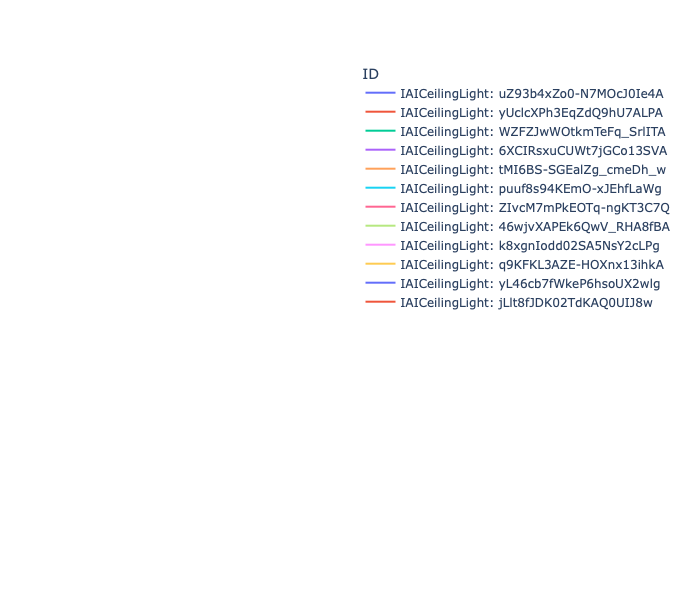

In [13]:
plot_trajectories(get_object_ids("IAICeilingLight"))

No movement for IAIIslandArea: XYIgNjEFVU6q-71AupPIzQ detected
No movement for IAIOvenArea: bWghhYQVaUaDIsnKdB1Wqg detected
No movement for IAIFridgeArea: nogn08Zpz0y42SDhk58dSQ detected
No movement for IAISinkArea: NqvT_jLu8kehncV8m8dSSg detected
No movement for IAIOvenCase: VzjIHZXtVkOgvqbK0Cbxfw detected
No movement for IAIDishwasherCase: 5t3rc1bBrk2CZy4TsWBRcQ detected
No movement for IAIFridgeCasing: -1L7J3oFRkK7m6wTwMLtmQ detected
No movement for IAICooktop: UoPRcmY1I0qT5MPZXw9VXg detected
No movement for IAISink: 0E5uQZuTE0Kw4b_YLVoKWw detected
No movement for IAIOvenKnob: af7T-0EiI0mMDKRFdgwBTA detected
No movement for IAIOvenKnob: yAI8zWODK0uLI_U0jyAvcg detected
No movement for IAIOvenKnob: sVRX3BMWyUOghE_PsZPZWA detected
No movement for IAIOvenKnob: zRiQRLC9n0W367pMbEv2kw detected
No movement for IAIOvenKnob: 5sa2mVV68Eur7BSDigQDkg detected
No movement for IAIOvenBars: wVmTFX8D7kSHkKqYgFE7CA detected
No movement for IAIDrawerW60H29: oG0s8XrUhk-KPZXtQeurgw detected
No movement

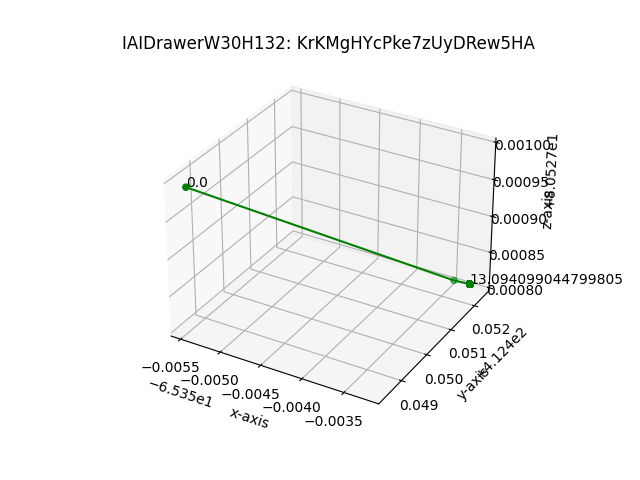

No movement for IAIDrawerW30H132: MLcaV2WY1Uuf44ED3S5_ag detected
No movement for IAIOvenDoor: HCL6OjLnRECT3yB4rzhYPw detected


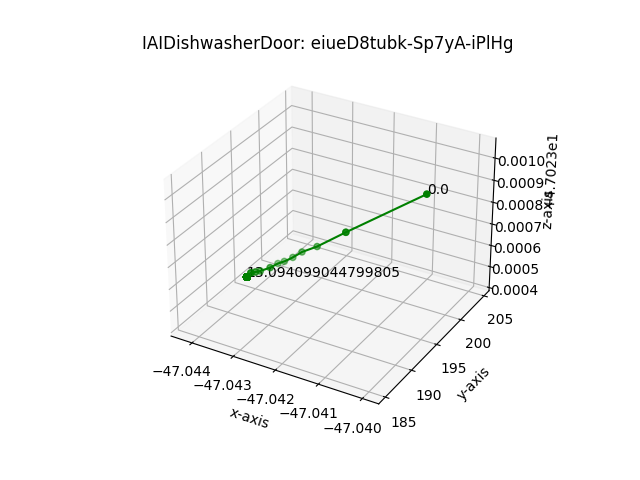

No movement for IAIDishwasherLowerRack: _0Dwd6opXUyImm9_yY0uCw detected
No movement for IAIDishwasherUpperRack: MXcLSBHNyUWQsTN847usYw detected
No movement for IAIDrawerW80H29: 5hJLcyxGBEaaac6EwzeRQQ detected
No movement for IAIDrawerW80H29: 3tg-Fm83Uk-HcsML9MlKBA detected
No movement for IAIDrawerW80H14: zSYT-nwfaUaWUq178RGEBQ detected
No movement for IAIDrawerW60H58: e6UUPFnkRkqUU_bpeEhqwQ detected
No movement for IAIDrawerW60H29: D-O7uSgMaEi3k2jMMmTbXg detected


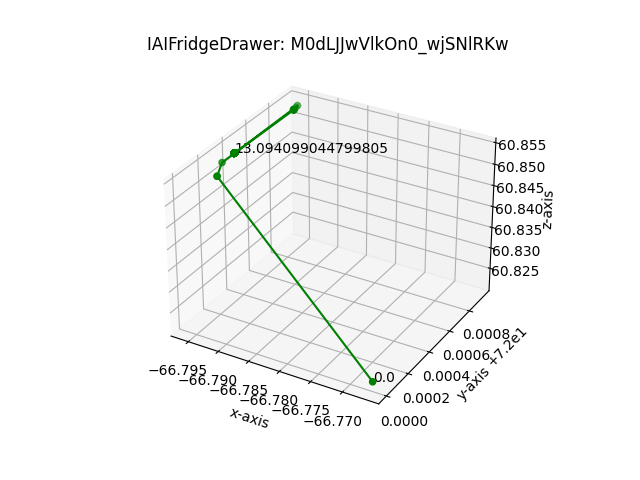

No movement for IAIFridgeDoor: vnNwgJqwR0WwX9SWZGMnyw detected
No movement for IAIFridgeDoorPanel: -QeNmQ8TxEeWbNdtmxZEMA detected
No movement for LightBlockFridge: nlIQMqakOU-6xajkG1XrGQ detected
No movement for LinearJoint: sRdV8oC3vkWjObNI3zQPpg detected
No movement for LinearJoint: sycAYF3Bi0eZP8w2OFFlEw detected
No movement for LinearJoint: GBMVj5okCEWyDKQK-VPaQA detected
No movement for LinearJoint: KNvUzvJ1_kKgvCDr8Wq1Uw detected
No movement for LinearJoint: er-HM-Pe3UCnUS-_pUzf8A detected


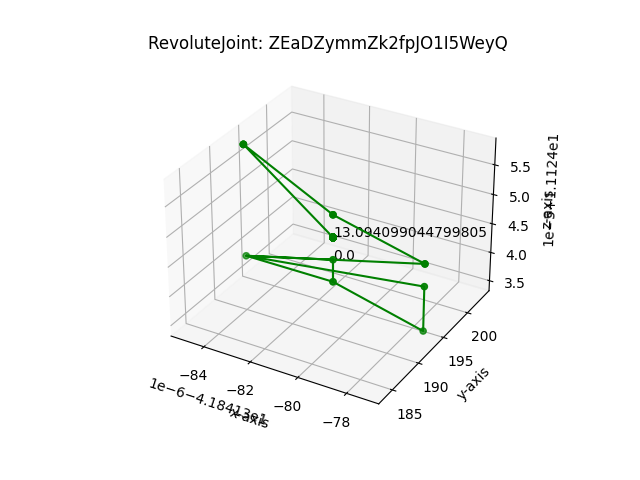

No movement for LinearJoint: CGrE1G6ScEyvdkZcx9b5rQ detected
No movement for LinearJoint: f1bQyx99gUqHTt-GCgN90A detected


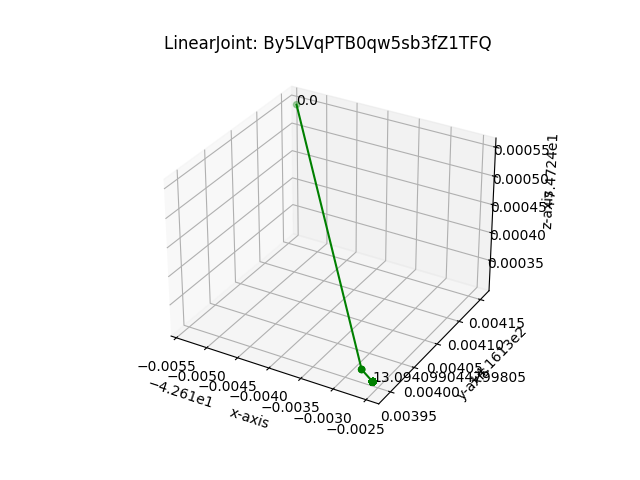

No movement for LinearJoint: GGds2ofmHUilnTn-3_7qzQ detected
No movement for LinearJoint: mKCRMByHZket8O45F9UrBQ detected
No movement for LinearJoint: HBmlaTZZLU2aP4H6zsbI3A detected
No movement for RevoluteJoint: htmHzWshcUG4gXZJHVip2g detected
No movement for LinearJoint: mEXRlcw_qUSLg68wssmLWA detected
No movement for LinearJoint: TuUcwP8IfE6xGEKD5DtdoQ detected
No movement for LinearJoint: Z7MS0O-MxEe2bVobp1oV0g detected
No movement for LinearJoint: Y0rxUgKkvUqtJ25G_waIXQ detected
No movement for LinearJoint: LUwjPJWn6k67eeD4cociHA detected
No movement for LinearJoint: rOvbIpr3Sk2RKkZnUO_oMQ detected


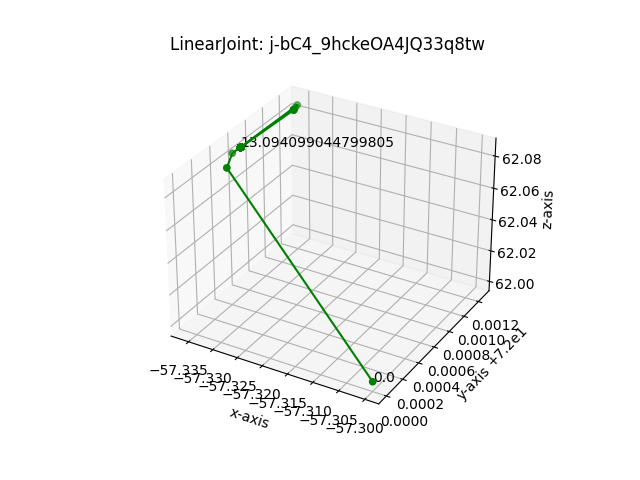

No movement for RevoluteJoint: IsxvqIB33UKdeQn3XncwWA detected
No movement for RevoluteJoint: d1PpPi9TUke638JctBJuQA detected
No movement for IAITapMiddle: D4w1tO5HcEqwoQwgHEOtQA detected
No movement for IAIFilterSmall: mfF-FpccDEmwETvytEnjWA detected
No movement for IAIFilterBig: zmIK2Ef4ykqXrSxA1f9bOQ detected
No movement for IAIFridgeShelfGlas: 1fhnPceD1kup941faWnxYw detected
No movement for IAIFridgeShelf: _4-CCqIV7kylvR9g2NYlvg detected
No movement for IAIFridgeShelf: _ZUfQrc6oUuYoGpF8CnrmA detected
No movement for IAIFridgeShelf: lm7utwBdeEKTNol1jQkwQw detected
No movement for LightIndividual: yibeopAIfUWchrxhfSwG2g detected
No movement for IAIHandleW60: BSLOjD-eNUCtH5EbZzfE-Q detected
No movement for IAIHandleW60: P9Snh3S9PUaP7XR2O4H-7g detected
No movement for IAIHandleW60: yQ79yhPc9kypjKobrR2QDg detected
No movement for IAIHandleW100: JNRYjsPlIkCn819cDpsfBA detected
No movement for IAIHandleW100: DJXMxLMX1EajofMkDyvgpA detected
No movement for IAIHandleW60: LorVQmS0yEOGnlTWx9d

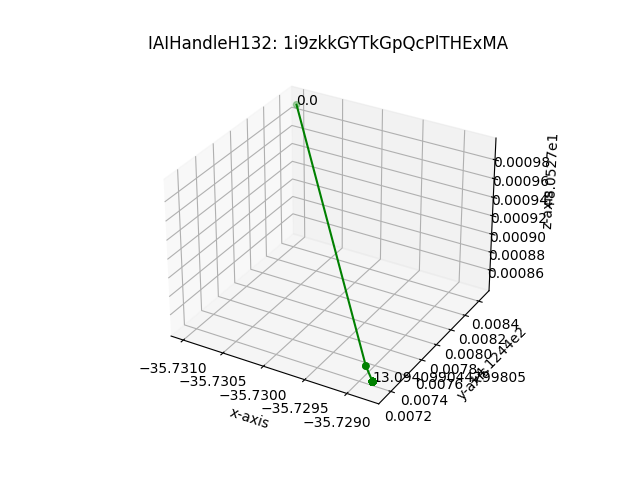

No movement for IAIHandleH132: ATdFfGnF30a74biJRdh0vg detected
No movement for IAIHandleW60: MNj2rH5L8EmQnP5RuLr5mw detected
No movement for IAIHandleW60: PmWVReKctUWww93tCKLANw detected
No movement for IAIOvenDoorHandle: DmFHsC85_km-ff0qxLoXtQ detected


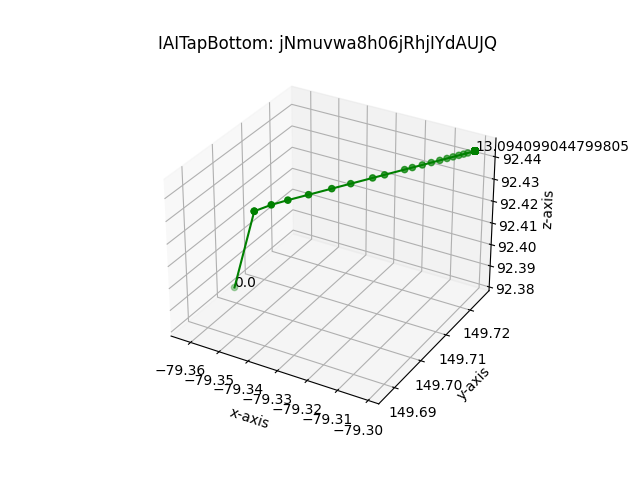

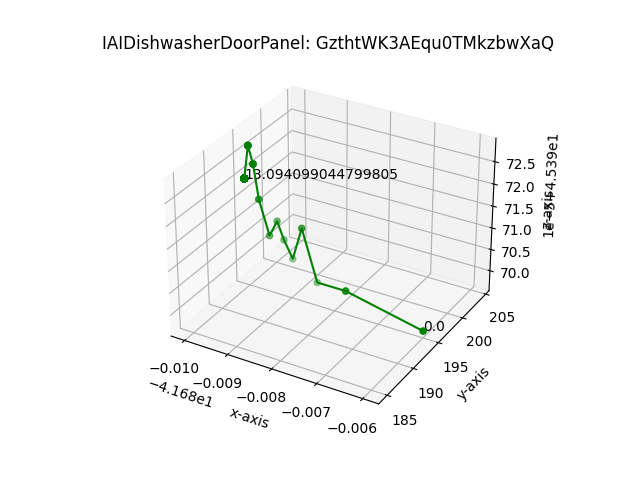

No movement for IAIHandleW80: q4JUyG-SF0ubFWrsS6IHMA detected
No movement for IAIHandleW80: k4VkAY0Yc06JX44GSNskzA detected
No movement for IAIHandleW80: _slIH9rGuUuYTCJA2Hd2Qg detected
No movement for IAIHandleW60: 34QQGL7m50mVqJdSwzeWGw detected
No movement for IAIHandleW60: dHeD1MqnYUS1jBfureO4Rg detected


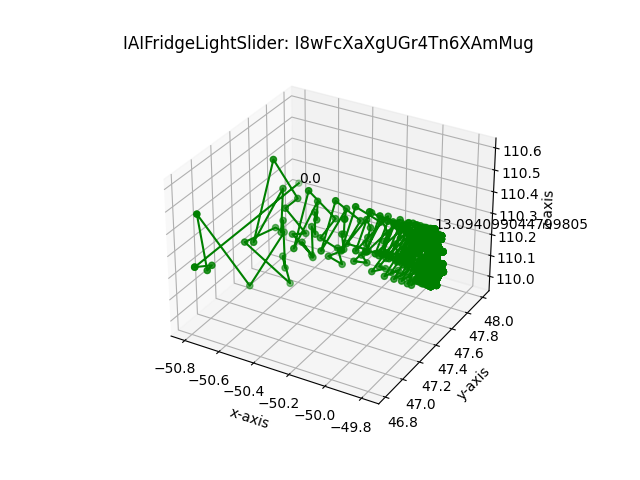

No movement for IAIFridgeDoorShelfBig: PAmCnAsOL0ecmX0pD1oC1Q detected
No movement for IAIFridgeDoorShelf: k-eElgScOUSNvarXoHc06w detected
No movement for IAIFridgeDoorShelf: SpTd6RtyU0GRffcS9iIBQA detected
No movement for IAIHandleW86: zrtZ6CfnMU-rdQwqyymSrA detected
No movement for LinearJoint: wXlJSdGaZkOcg5FYjn6NJA detected
No movement for IAIFRidgeHingeBase: 57mMaHIAm0yQYKhIqC_gEA detected
No movement for RevoluteJoint: ehGShxwXmEapKOkXEgJqDA detected
No movement for RevoluteJoint: 8udO5IBNuECXiMucTft7dw detected
No movement for RevoluteJoint: aVfBJIf7-0iBP5TSvnnnFg detected
No movement for RevoluteJoint: bTp7UGIvSUasLyyTubPGKg detected
No movement for RevoluteJoint: 7GxAYDHo5kuq8wARdmhmfQ detected
No movement for RevoluteJoint: ZvB9zhh6IkyI8Uac1qTbVg detected


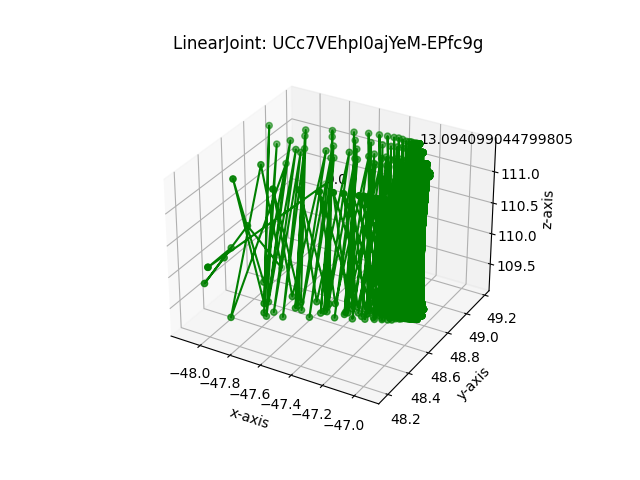

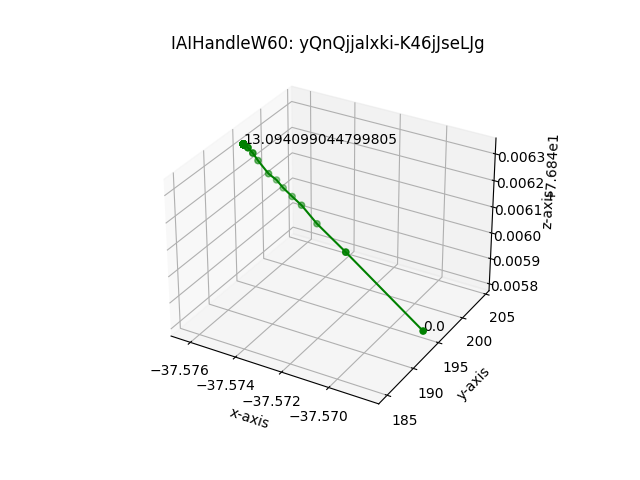

No movement for IAITapTop: LLgBA7r4SUanl1X5VuXXHw detected
No movement for RevoluteJoint: RAwi1LYnKkKz0gPPPOWqBQ detected


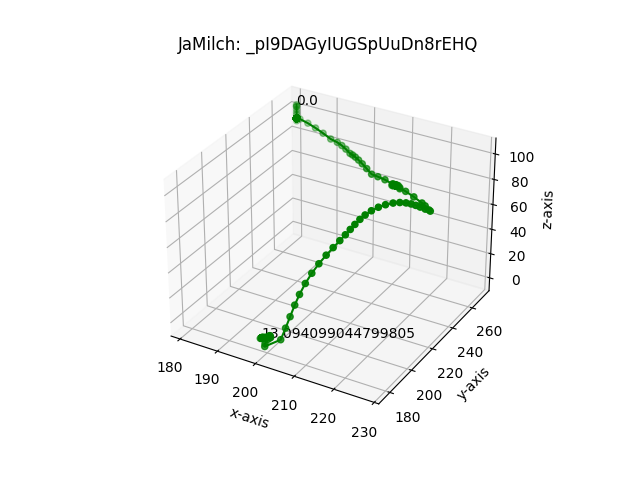

No movement for IAIWindowTypeA: pnI0taXMNkmQF9ubfBHuvA detected
No movement for IAIWindowTypeC: oY9TVNNEY06-vCdOkhLwlQ detected
No movement for IAIWindowTypeA: WgFt5Gu2QUSuCNe_2SzUpQ detected
No movement for IAIWindowTypeA: n_6igFBvYUKP51zkZyCA2w detected
No movement for IAIWindowTypeA: Phzev03lrE6WoRJViRO2sQ detected
No movement for IAIWindowTypeA: xB-97GmPXk-DASRJQP9uNQ detected
No movement for IAIWindowTypeB: BardCoVRP0WE-cK3Iad91g detected
No movement for IAIWindowTypeB: Mxe1GNkH_E6CpXPxJTdmxQ detected
No movement for IAIDoorA: 8TqzaPMJn0WPr5gR2cKrzA detected
No movement for IAIDoorB: ukiJnuNONkGQgUFtgMUi2A detected
No movement for IAILabFloor: 9jrJzTZvSkqUjwIvPEavYA detected
No movement for IAIDoorC: hYkSrYyySkCXIqWEDamDrQ detected
No movement for IAIWindowTypeC: 4Q_AQTxRa0i25PcXjohcCQ detected
No movement for IAIWindowTypeA: Itfe85ueU02R5L7DMWGeLQ detected
No movement for IAILabWalls: mWb6qq1U4U-WriYRBdjMMg detected
No movement for IAIPosterFrameA0: _24AjepVIU6a-biVSahiYQ detecte

In [14]:
for i in list(id_to_class.keys())[0:150]:
    plot_trajectory_fast(i)

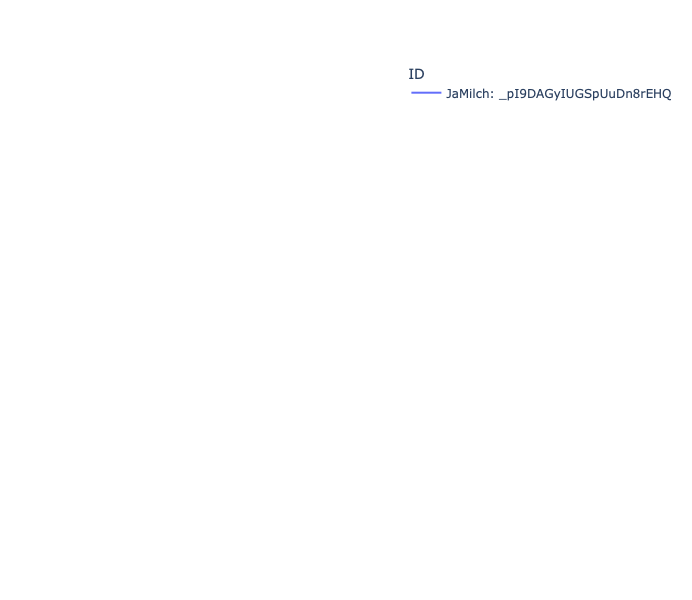

In [15]:
plot_trajectories(get_object_ids("JaMilch"))

In [16]:
get_object_ids("JaMilch")

['_pI9DAGyIUGSpUuDn8rEHQ']